In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import holidays
import optuna

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
urbanbus_data = pd.read_csv('../urbanbus_data/SER_0b91_start_aggregated.csv')

df = urbanbus_data.groupby(["Ride_start_datetime", "Bus_Service_Number", "Direction", "Boarding_stop_stn", "Alighting_stop_stn"], as_index=False)["Passenger_Count"].sum()
df['Ride_start_datetime'] = pd.to_datetime(df['Ride_start_datetime'], errors='coerce')
df = df.sort_values('Ride_start_datetime').reset_index(drop=True)

print(f"Total records: {len(df):,}")
print(f"Date range: {df['Ride_start_datetime'].min()} to {df['Ride_start_datetime'].max()}\n")

Total records: 600,672
Date range: 2017-10-01 00:00:00 to 2018-03-31 23:45:00



In [3]:
# Datetime features
df['hour'] = df['Ride_start_datetime'].dt.hour
df['minute'] = df['Ride_start_datetime'].dt.minute
df['day'] = df['Ride_start_datetime'].dt.day
df['dayofweek'] = df['Ride_start_datetime'].dt.dayofweek
df['month'] = df['Ride_start_datetime'].dt.month
df['year'] = df['Ride_start_datetime'].dt.year
df['week_of_year'] = df['Ride_start_datetime'].dt.isocalendar().week

# Cyclic encoding
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minute_sin'] = np.sin(2 * np.pi * df['minute'] / 60)
df['minute_cos'] = np.cos(2 * np.pi * df['minute'] / 60)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

# Peak hour flags
peak_hours = df.groupby('hour')['Passenger_Count'].sum().nlargest(2).index.tolist()
df['is_peak_hour'] = df['hour'].isin(peak_hours).astype(int)

# Weekend and holiday flag
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
china_holidays = holidays.country_holidays('CN')
df['is_holiday'] = df['Ride_start_datetime'].dt.date.isin(china_holidays).astype(int)

# Route identifier
df['route'] = df['Boarding_stop_stn'] + '_to_' + df['Alighting_stop_stn']
df = df.sort_values(['route', 'Ride_start_datetime']).reset_index(drop=True)

# Lag Features
for lag in [1, 2, 3, 4, 8, 12, 24]:
    df[f'lag_{lag}'] = df.groupby('route')['Passenger_Count'].shift(lag)

for window in [4, 8, 12, 24]:
    df[f'rolling_mean_{window}'] = (
        df.groupby('route')['Passenger_Count']
        .shift(1)
        .rolling(window=window)
        .mean()
    )
    df[f'rolling_std_{window}'] = (
        df.groupby('route')['Passenger_Count']
        .shift(1)
        .rolling(window=window)
        .std()
    )


lag_roll_cols = [col for col in df.columns if col.startswith(('lag_', 'rolling_'))]
df = df.dropna(subset=lag_roll_cols).reset_index(drop=True)

In [4]:
max_date = df['Ride_start_datetime'].max()
cutoff_date = max_date - timedelta(days=27)

train_df = df[df['Ride_start_datetime'] < cutoff_date].copy()
test_df = df[df['Ride_start_datetime'] >= cutoff_date].copy()

print(f"Training Set: {len(train_df):,} records ({train_df['Ride_start_datetime'].min()} to {train_df['Ride_start_datetime'].max()})")
print(f"Test Set: {len(test_df):,} records ({test_df['Ride_start_datetime'].min()} to {test_df['Ride_start_datetime'].max()})")
print(f"Split: {len(train_df)/len(df)*100:.1f}% train / {len(test_df)/len(df)*100:.1f}% test\n")

Training Set: 497,989 records (2017-10-01 16:15:00 to 2018-03-04 23:30:00)
Test Set: 89,785 records (2018-03-04 23:45:00 to 2018-03-31 23:45:00)
Split: 84.7% train / 15.3% test



In [5]:
cat_cols = ['Boarding_stop_stn', 'Alighting_stop_stn']

# All numerical features
num_cols = [
    'hour', 'minute', 'day', 'dayofweek', 'month', 'year', 'week_of_year',
    'hour_sin', 'hour_cos', 'minute_sin', 'minute_cos', 
    'dow_sin', 'dow_cos', 'month_sin', 'month_cos',
    'is_weekend', 'is_holiday', 'is_peak_hour']

# Add lag and rolling features
lag_roll_cols = [col for col in train_df.columns if col.startswith(('lag_', 'rolling_'))]
num_cols.extend(lag_roll_cols)

# Prepare feature matrices
X_train = train_df[cat_cols + num_cols].copy()
y_train = train_df['Passenger_Count'].copy()
X_test = test_df[cat_cols + num_cols].copy()
y_test = test_df['Passenger_Count'].copy()

print(f"Feature matrices:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  Total features: {len(cat_cols + num_cols)}\n")

Feature matrices:
  X_train: (497989, 35)
  X_test: (89785, 35)
  Total features: 35



In [10]:
preprocessor = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), cat_cols),
    ('scaler', StandardScaler(), num_cols)
], remainder='drop', verbose_feature_names_out=False)


pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', lgb.LGBMRegressor(
        n_estimators=500,
        max_depth=10,
        learning_rate=0.05,
        min_child_samples=20,
        n_jobs=-1,
        num_leaves=40,
        reg_alpha=0.5,
        reg_lambda=1.0,
    ))
])

print("Training LightGBM model...")
pipe.fit(X_train, y_train)
print("✓ Training complete!\n")

y_train_pred = pipe.predict(X_train)
y_test_pred = pipe.predict(X_test)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    if np.sum(nonzero_idx) == 0:
        return 0.0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print("="*70)
print("MODEL PERFORMANCE")
print("="*70)
print(f"\nTraining Set:")
print(f"  MAE:   {train_mae:.4f}")
print(f"  RMSE:  {train_rmse:.4f}")
print(f"  R²:    {train_r2:.4f}")
print(f"  MAPE:  {train_mape:.2f}%")

print(f"\nTest Set:")
print(f"  MAE:   {test_mae:.4f}")
print(f"  RMSE:  {test_rmse:.4f}")
print(f"  R²:    {test_r2:.4f}")
print(f"  MAPE:  {test_mape:.2f}%")

print(f"\nOverfitting Check:")
overfitting_gap = train_r2 - test_r2
print(f"  R² Gap: {overfitting_gap:.4f}")
if overfitting_gap > 0.15:
    print(f"  ⚠️  WARNING: Significant overfitting detected")
elif overfitting_gap > 0.05:
    print(f"  ⚡ CAUTION: Slight overfitting")
else:
    print(f"  ✓ OK: Good generalization")
print("="*70 + "\n")

Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1921
[LightGBM] [Info] Number of data points in the train set: 497989, number of used features: 97
[LightGBM] [Info] Start training from score 1.560767
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
✓ Training complete!



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MODEL PERFORMANCE

Training Set:
  MAE:   0.6483
  RMSE:  1.0064
  R²:    0.3306
  MAPE:  41.38%

Test Set:
  MAE:   0.6540
  RMSE:  1.0474
  R²:    0.2928
  MAPE:  41.73%

Overfitting Check:
  R² Gap: 0.0379
  ✓ OK: Good generalization



/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


TOP 20 FEATURE IMPORTANCES
        feature  importance
rolling_mean_24        2548
           hour        2480
 rolling_mean_4        1819
 rolling_std_24        1808
            day        1718
       hour_sin        1439
          lag_1        1422
 rolling_mean_8        1416
rolling_mean_12        1389
   week_of_year        1343
         minute        1338
  rolling_std_4        1295
 rolling_std_12        1286
      dayofweek        1175
  rolling_std_8        1113
          lag_2        1099
          lag_3         878
         lag_24         836
       hour_cos         826
          lag_4         799



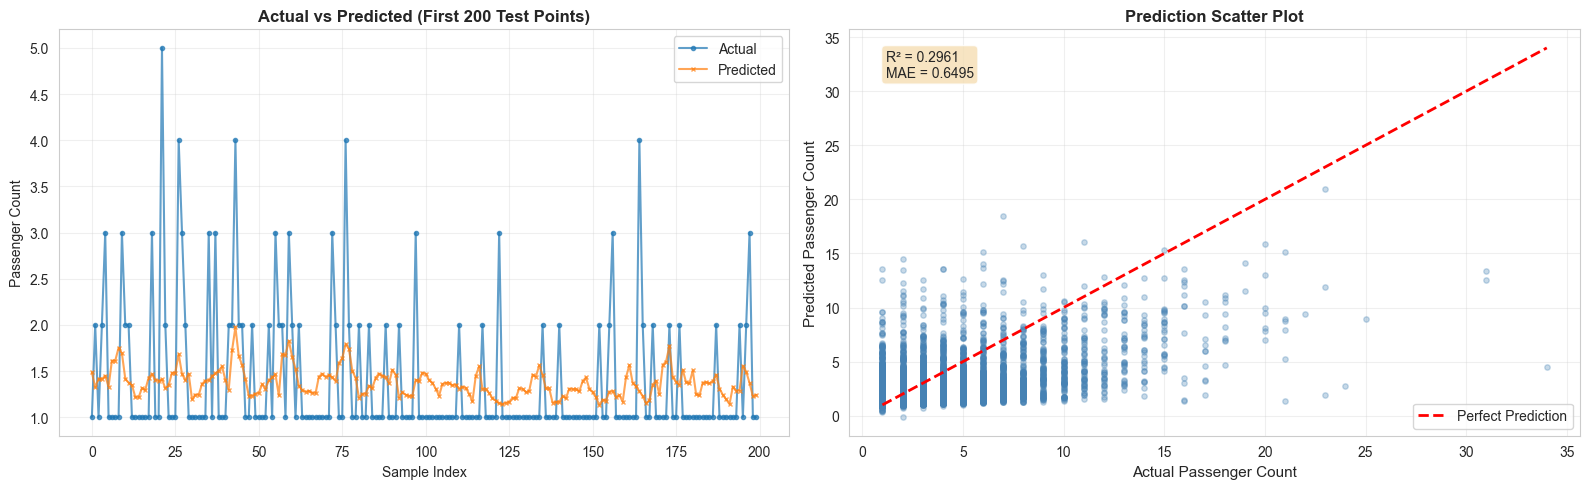

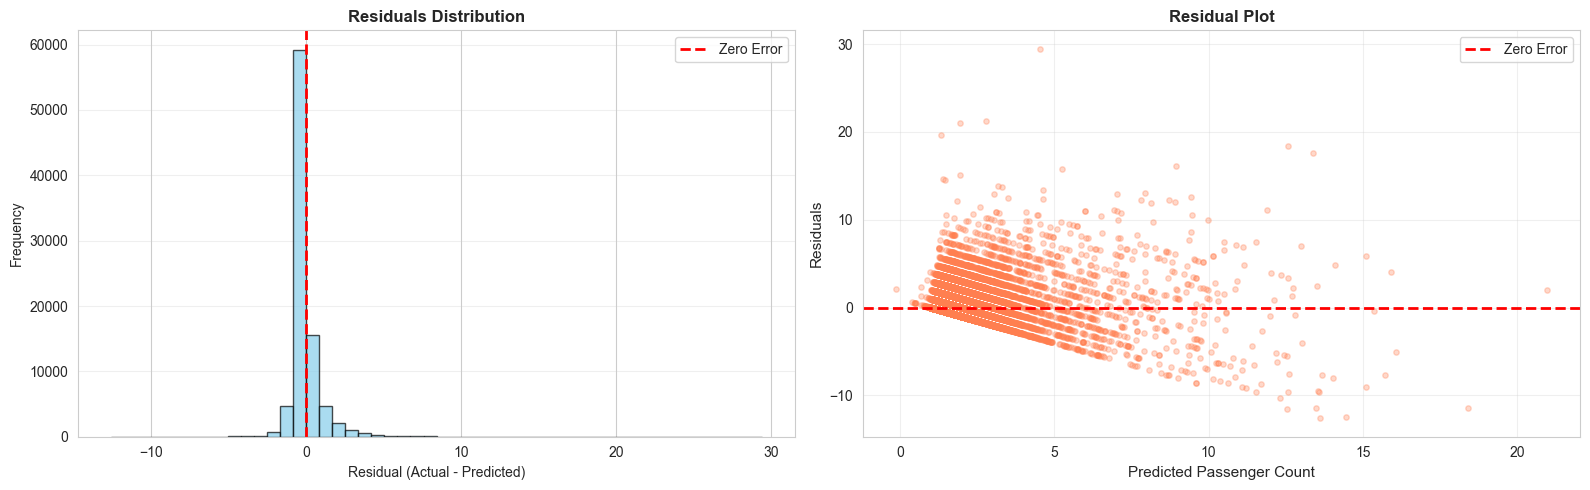

/var/folders/ry/8lz3tm751074s32_zb2xmhpc0000gn/T/ipykernel_2176/2054434376.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')


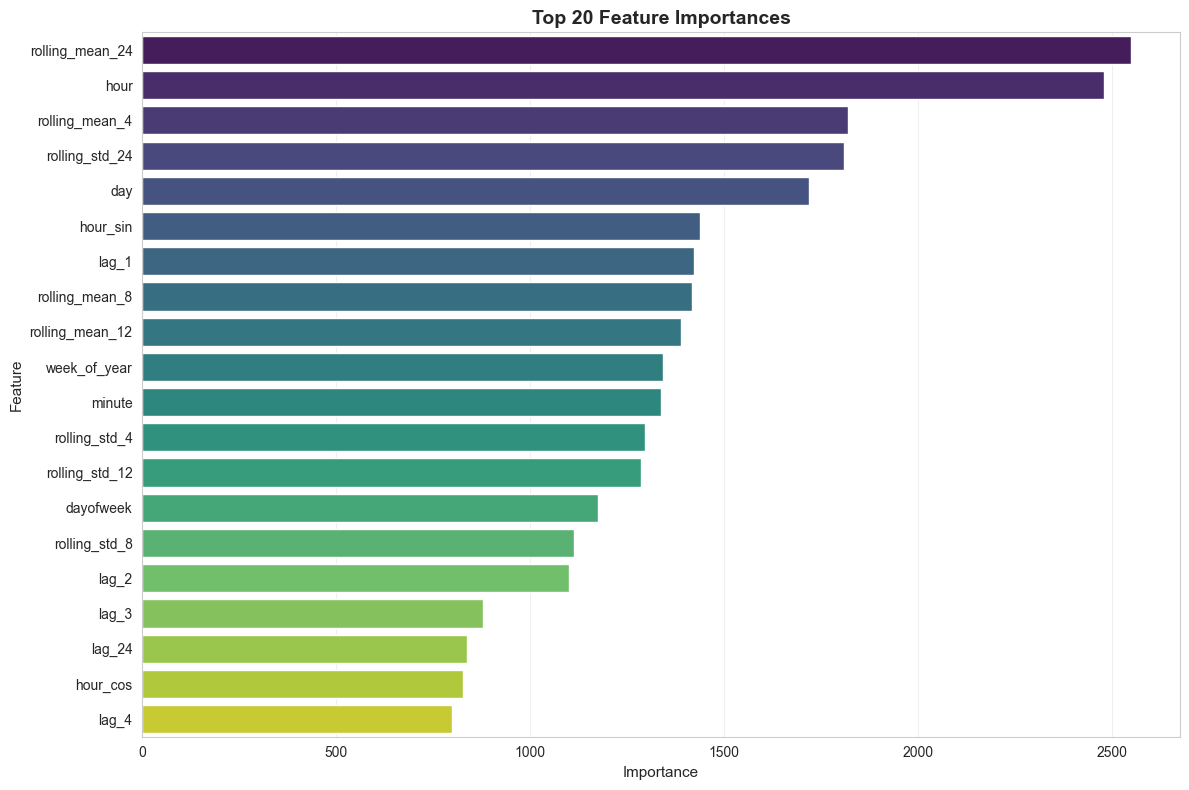

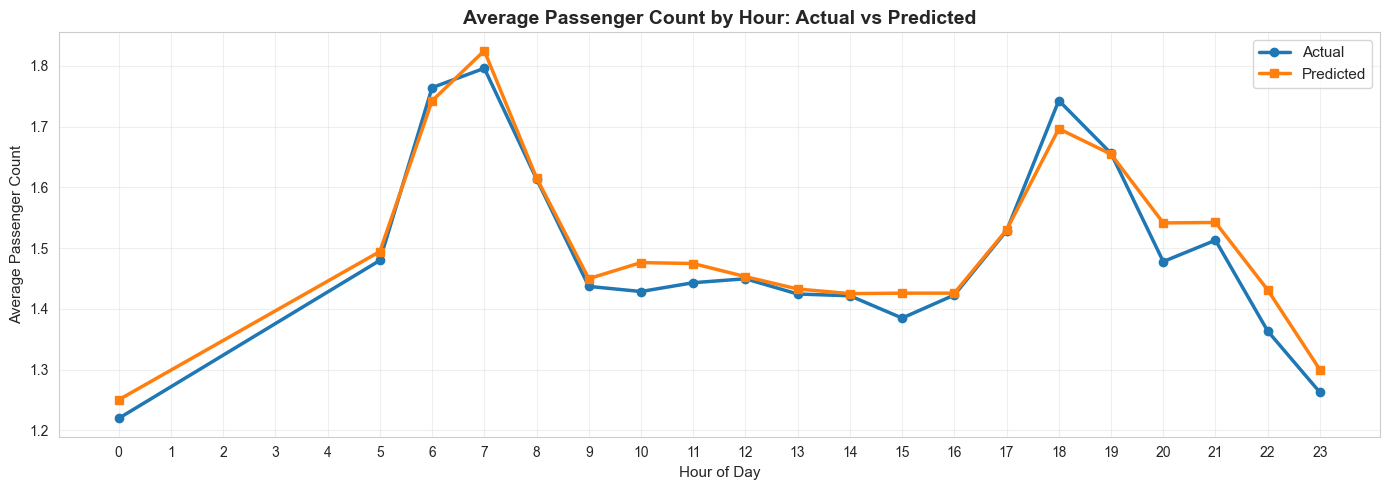

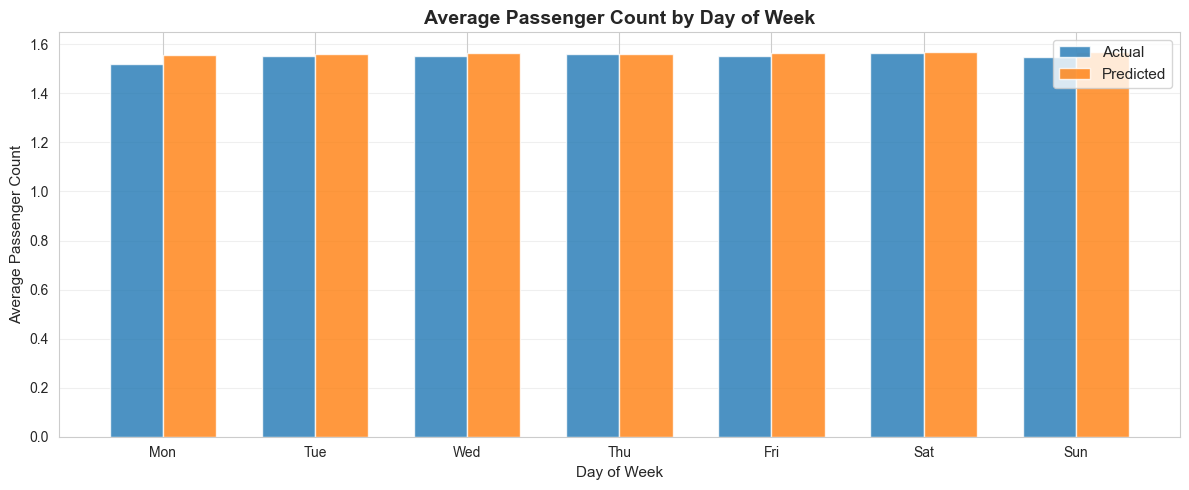

In [7]:
# Feature Importance
feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
importances = pipe.named_steps['model'].feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("="*70)
print("TOP 20 FEATURE IMPORTANCES")
print("="*70)
print(feat_imp.head(20).to_string(index=False))
print("="*70 + "\n")

# Visualizations
sns.set_style("whitegrid")

# 1. Actual vs Predicted Line Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sample_size = min(200, len(y_test))
axes[0].plot(range(sample_size), y_test.values[:sample_size], 
             label='Actual', marker='o', markersize=3, alpha=0.7, linewidth=1.5)
axes[0].plot(range(sample_size), y_test_pred[:sample_size], 
             label='Predicted', marker='x', markersize=3, alpha=0.7, linewidth=1.5)
axes[0].set_title("Actual vs Predicted (First 200 Test Points)", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Sample Index")
axes[0].set_ylabel("Passenger Count")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Scatter Plot
axes[1].scatter(y_test, y_test_pred, alpha=0.3, s=15, color='steelblue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel("Actual Passenger Count", fontsize=11)
axes[1].set_ylabel("Predicted Passenger Count", fontsize=11)
axes[1].set_title("Prediction Scatter Plot", fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].text(0.05, 0.95, f'R² = {test_r2:.4f}\nMAE = {test_mae:.4f}', 
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
plt.tight_layout()
plt.show()

# 3. Residuals Analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
residuals = y_test - y_test_pred

axes[0].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[0].set_title("Residuals Distribution", fontweight='bold', fontsize=12)
axes[0].set_xlabel("Residual (Actual - Predicted)")
axes[0].set_ylabel("Frequency")
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

axes[1].scatter(y_test_pred, residuals, alpha=0.3, s=15, color='coral')
axes[1].axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Error')
axes[1].set_xlabel("Predicted Passenger Count", fontsize=11)
axes[1].set_ylabel("Residuals", fontsize=11)
axes[1].set_title("Residual Plot", fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Feature Importances
plt.figure(figsize=(12, 8))
top_features = feat_imp.head(20)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title("Top 20 Feature Importances", fontweight='bold', fontsize=14)
plt.xlabel("Importance", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# 5. Hourly Performance
test_df_eval = test_df.copy()
test_df_eval['predicted'] = y_test_pred
hourly_performance = test_df_eval.groupby('hour').agg({
    'Passenger_Count': 'mean',
    'predicted': 'mean'
}).reset_index()

plt.figure(figsize=(14, 5))
plt.plot(hourly_performance['hour'], hourly_performance['Passenger_Count'], 
         marker='o', label='Actual', linewidth=2.5, markersize=6)
plt.plot(hourly_performance['hour'], hourly_performance['predicted'], 
         marker='s', label='Predicted', linewidth=2.5, markersize=6)
plt.xlabel("Hour of Day", fontsize=11)
plt.ylabel("Average Passenger Count", fontsize=11)
plt.title("Average Passenger Count by Hour: Actual vs Predicted", fontweight='bold', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

# 6. Day of Week Performance
dow_performance = test_df_eval.groupby('dayofweek').agg({
    'Passenger_Count': 'mean',
    'predicted': 'mean'
}).reset_index()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12, 5))
x = np.arange(len(dow_labels))
width = 0.35
plt.bar(x - width/2, dow_performance['Passenger_Count'], width, label='Actual', alpha=0.8)
plt.bar(x + width/2, dow_performance['predicted'], width, label='Predicted', alpha=0.8)
plt.xlabel("Day of Week", fontsize=11)
plt.ylabel("Average Passenger Count", fontsize=11)
plt.title("Average Passenger Count by Day of Week", fontweight='bold', fontsize=14)
plt.xticks(x, dow_labels)
plt.legend(fontsize=11)
plt.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()